# FunCube+ Mode Dynamic Transponder Analysis and Simulation Model for AMSAT-UK

The proposed "fast uplink, slow downlink" dynamic transponder concept for AMSAT-UK's upcoming FunCube+ 2U CubeSat represents an interesting power-conservation strategy, but requires careful analysis of buffering requirements, timing constraints, and mode compatibility. Open Research Institute (ORI) was invited by AMSAT-UK to support and propose designs for an upcoming launch opportunity. This article is the first in a series from ORI about this collaboration. 

## Challenges

Buffer size requirements need to be calculated and tested. We must store potentially entire passes worth of data. We have latency challenges. Communication becomes store-and-forward rather than real-time. FPGA complexity is mainly in the buffering and control logic. We need to define the user experience. We need to define the Doppler on both fast receive and slow transmit.

## Mode Analysis for FunCube+

Looking at the operating context of FunCube-1 (AO-73) we have an uplink of 435.150-435.130 MHz (Mode U, 20 kHz bandwidth, LSB) and a downlink of 145.950-145.970 MHz (Mode V, USB). This is a traditional transponder with an inverting linear at 300 mW PEP. Telemetry is 145.935 MHz BPSK, 30/300 mW. What are some reasonable options for FunCube+? 

### 1) Digital Voice, Data, and Keyboard Mode
Fast Uplink of 435.xxx MHz with 81 kHz bandwidth Opulent Voice protocol. 
Slow Downlink of 145.xxx MHz with a 20 kHz bandwidth BPSK data stream. This is the current bandwidth limit.
Bandwidth is traded off against latency and satellite power budget for up to ~4:1 compression.

Open source implementation for FPGA can be found at https://github.com/OpenResearchInstitute/pluto_msk. Advantages include clear quantifiable data rates for buffering calculations and high fidelity voice integrated with keyboard chat, data, and control messages. 

### 2) Digital Data Mode or Pure Store and Forward
Fast Uplink at 435.xxx MHz with FSK/PSK at 9600 bps. Mode such as G3RUH.
Slow Downlink at 145.xxx MHz with BPSK at 1200 bps. The optimization of the rates would need to be optimized and analyzed, but we could achieve an 8:1 radio of data rate compression. 

This is relatively easy to implement in an FPGA. There are clear quantifiable data rates for buffering calculations. There is potential compatibility with FUNcube Dashboard software ecosystem. This would be suitable for telemetry and educational data collection.


```
┌─────────────────────────────────────────────────────────┐
│                    Ground Station Domain                │
│  - High Power Transmitter                               │
│  - Fast uplink mode                                     │
│  - Receives slow downlink mode                          │
└─────────────────────────────────────────────────────────┘
                        Fast UP          │
                          │          Slow DOWN
┌─────────────────────────────────────────────────────────┐
│              Satellite Transponder Domain               │
│  ┌──────────────────────────────────────────────────┐   │
│  │  RF Frontend (Mode U/V or S-band)                │   │
│  └──────────────────────────────────────────────────┘   │
│                          |                              │
│  ┌──────────────────────────────────────────────────┐   │
│  │  Demodulator (Fast Rate)                         │   │
│  │  - Doppler compensation                          │   │
│  │  - Symbol timing recovery                        │   │
│  └──────────────────────────────────────────────────┘   │
│                          |                              │
│  ┌──────────────────────────────────────────────────┐   │
│  │  FPGA Processing Domain                          │   │
│  │  ┌────────────────────────────────────────────┐  │   │
│  │  │ Rate Buffer (FIFO)                         │  │   │
│  │  │ - Elastic storage                          │  │   │
│  │  │ - Flow control                             │  │   │
│  │  └────────────────────────────────────────────┘  │   │
│  │  ┌────────────────────────────────────────────┐  │   │
│  │  │ Power Management Controller                │  │   │
│  │  │ - Battery state monitoring                 │  │   │
│  │  │ - Transmit duty cycle control              │  │   │
│  │  └────────────────────────────────────────────┘  │   │
│  └──────────────────────────────────────────────────┘   │
│                          |                              │
│  ┌──────────────────────────────────────────────────┐   │
│  │  Modulator (Slow Rate)                           │   │
│  └──────────────────────────────────────────────────┘   │
│                          |                              │
│  ┌──────────────────────────────────────────────────┐   │
│  │  RF Transmitter (Lower power)                    │   │
│  └──────────────────────────────────────────────────┘   │
└─────────────────────────────────────────────────────────┘
```

## Jupyter Lab Notebook Python Classes

Link and design analysis was carried out in a Jupyter Lab Notebook in Python. Here is an explanation of the code and the results. 

### Python imports

We import the libraries that we need to run our code. These are helpful functions for math, plots, code organization, and variable enumeration.  

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum

### TransponderConfig Dataclass

A dataclass is a object oriented structure. A dataclass is a collection of members (variables or constants). A dataclass is composed only of members. It does not contain any function definitions. This is how we configure our uplink and downlink data rates, buffer sizes, pass duration, radio parameters, battery and solar capacities, and other values. We can have a separate dataclass for different configurations. If we want to change a configuration, or try out a different proposal, then we can simply import a different dataclass that corresponds to a different design. Keeping the data separate from the calculations helps make our analysis flexible and results in easier and better documentation. 

In [15]:
@dataclass
class TransponderConfig:
    """Configuration parameters for the dynamic transponder"""
    uplink_rate_bps: int = 9600
    downlink_rate_bps: int = 1200
    buffer_size_bytes: int = 65536
    pass_duration_sec: float = 600
    tx_power_watts: float = 0.3
    rx_power_watts: float = 0.1
    battery_capacity_wh: float = 10
    solar_power_watts: float = 4

### TransponderMode Class

This class sets up an *enumeration* of transponder modes. We can be in receiving, buffering, transmitting, or idle state. When we call TransponderMode(number) then it returns the mode corresponding to that number, as defined inside the class. 

In [16]:
class TransponderMode(Enum):
    RECEIVING = 1
    BUFFERING = 2
    TRANSMITTING = 3
    IDLE = 4

### DynamicTransponder Class

At the heart of the simulation are the DynamicTransponder Class methods (functions). This class contains a set of methods that we are going to be using in our mode analysis. The initialization function is listed first. This function is called whenever we create a DynamicTransponder Object. A TransponderConfig object is requried in order to creat a DynamicTransponder object. When we run an analysis, we create a TransponderConfig object first, then we use that list of values to set up a Transponder object. 

Separating configuration clases from the transponder class gives us flexibility and clarity. We can look at the values in the configuration file without having to search through a lengthy class full of function defintions for variables. We can have multiple configurations and then simply re-use the DynamicTransponder class with different configurations. This division of labor is very common in scientific Python programming and is a naturally good fit for the analysis of radio systems. 

We get many of the members of the DynamicTransponder class by importing all of the members from the TransponderConfig dataclass. This is our "starter set" of values. Each value from the Configuration dataclass is then available in TransponderConfig as self.config.name-of-variable-in-TransponderConfig-dataclass. 

Right after that, we also set up additional members for the Transponder object, such as self.buffer_fill_bytes and self.time_sec. 

In [17]:
class DynamicTransponder:
    def __init__(self, config: TransponderConfig):
        self.config = config
        self.buffer_fill_bytes = 0
        self.mode = TransponderMode.IDLE
        self.battery_level_wh = config.battery_capacity_wh
        self.time_sec = 0
        
        self.rx_data_total_bytes = 0
        self.tx_data_total_bytes = 0
        self.buffer_history = []
        self.battery_history = []
        self.mode_history = []
    def receive_uplink(self, duration_sec: float, duty_cycle: float = 0.5):
        data_bytes = int(self.config.uplink_rate_bps / 8 * duration_sec * duty_cycle)
        
        if self.buffer_fill_bytes + data_bytes > self.config.buffer_size_bytes:
            overflow = (self.buffer_fill_bytes + data_bytes - self.config.buffer_size_bytes)
            data_bytes -= overflow
            print(f"⚠️  Buffer overflow! Lost {overflow} bytes")
        
        self.buffer_fill_bytes += data_bytes
        self.rx_data_total_bytes += data_bytes
        
        power_consumed = self.config.rx_power_watts * duration_sec / 3600
        self.battery_level_wh -= power_consumed
        
        self.mode = TransponderMode.RECEIVING
    def transmit_downlink(self, duration_sec: float):
        data_bytes = int(self.config.downlink_rate_bps / 8 * duration_sec)
        
        if data_bytes > self.buffer_fill_bytes:
            data_bytes = self.buffer_fill_bytes
        
        self.buffer_fill_bytes -= data_bytes
        self.tx_data_total_bytes += data_bytes
        
        power_consumed = self.config.tx_power_watts * duration_sec / 3600
        self.battery_level_wh -= power_consumed
        
        self.mode = TransponderMode.TRANSMITTING
    def solar_charge(self, duration_sec: float, illumination: float = 1.0):
        power_gained = (self.config.solar_power_watts * illumination * duration_sec / 3600)
        self.battery_level_wh = min(self.battery_level_wh + power_gained, self.config.battery_capacity_wh)
    def log_state(self):
        self.buffer_history.append(self.buffer_fill_bytes)
        self.battery_history.append(self.battery_level_wh)
        self.mode_history.append(self.mode.value)
    def simulate_pass(self, pass_duration_sec: float = 600):
        timestep = 10
        
        for t in np.arange(0, pass_duration_sec, timestep):
            self.time_sec = t
            
            if t < pass_duration_sec / 2:
                self.receive_uplink(timestep, duty_cycle=0.6)
                self.solar_charge(timestep, illumination=0.5)
            else:
                if self.buffer_fill_bytes > 0:
                    self.transmit_downlink(timestep)
                else:
                    self.mode = TransponderMode.IDLE
                self.solar_charge(timestep, illumination=0.5)
            
            self.log_state()
            
        return self.get_statistics()
    
    def get_statistics(self):
        compression_ratio = self.config.uplink_rate_bps / self.config.downlink_rate_bps
        buffer_max_utilization = max(self.buffer_history) / self.config.buffer_size_bytes * 100
        
        return {
            'compression_ratio': compression_ratio,
            'rx_total_kb': self.rx_data_total_bytes / 1024,
            'tx_total_kb': self.tx_data_total_bytes / 1024,
            'buffer_max_util_%': buffer_max_utilization,
            'battery_end_wh': self.battery_level_wh,
            'battery_used_wh': self.config.battery_capacity_wh - self.battery_level_wh
        }

### receive_uplink Class Method

The receive_uplink method simulates how the satellite receives data from ground stations. It calculates how many bytes of data arrive during a given time period, checks if there's room in the buffer to store them, and keeps track of power consumption. If the buffer fills up, excess data is lost. When we lose data, we call it an overflow. 

The inputs, or arguments, to receive_uplink are the DynamicTransponder object itself (called "self"), a duration in seconds, and a duty cycle. 

The first thing we do is find out how many bytes were transmitted. Ground stations transmit at a fixed bit rate. For example, 9600 bits per second. This is defined in the DynamicTransponder object, which we know as "self". The transmitted bit rate is one of those values that was passed in to the DynamicTransponder object from the Configuration dataclass. Specifically, our bit rate is self.config.uplink_rate_bps. The receive_uplink method calculates how many bytes arrive at the satellite during the specified duration, accounting for a duty cycle, which is the percentage of time the ground station is actually transmitting.  

The second thing we do is check the available buffer space and add the incoming data. If, after we add the incoming data to the buffer, the result is larger than the size of the buger, then we have an overflow conditions. We report how many bytes were lost. The received data is stored in this buffer until it is retransmitted. We update the number of bytes in our buffer and we update hte number of total bytes that have been transmitted to the satellite. 

Receiving consumes power from the satellite's battery. The method then deducts energy based on receiver power draw and how long it took to receive. 

We then use our enumeration class to set our mode to RECEIVING. 

### transmit_downlink Class Method

The transmit_downlink method simulates how the satellite transmits data back down to ground stations. It calculates how many bytes can be sent during a given time period at the slower downlink rate, removes that data from the buffer, and tracks the power consumption of the transmitter.

The satellite transmits at a slower bit rate than it receives. For example, we might have a 20,000 bps downlink vs 54,200 bps uplink. Once we know how many bytes we're transmitting on the downlink, we can update the buffer. The method checks available buffer contents and transmits only what's available. We can't send what we don't have. We update our power consumption. Transmitting consumes more power than receiving, typically. The method deducts energy based on transmitter power draw and transmission duration. This allows us to trade buffer space for power efficiency in order to optimize uplink and downlink bit rates. We then set the state to TRANSMITTING. 

### solar_charge Class Method

solar_charge calculates the power we get from sunlight on our solar cells. We consume power with receiving and transmitting, and we gain power from solar charging. 

The solar_charge method simulates solar panel energy collection. It calculates how much power the panels generate during a time period, scaled by an 'illumination' factor (0.0 = total darkness, 1.0 = full sun). The battery is recharged up to its maximum capacity, but never beyond.

This is a very simple model. There are no orbital mechanics, no eclipse calculations, no Earth shadow geometry, no sun angle (would result in cosine losses), no seasonal variations, and no panel degradations. 

So, how can we use this method effectively?

We can calculate illumination based on orbital position. 

```
*Example 1: Simple LEO orbit approximation*

orbit_period_min = 97  # ~500 km altitude
eclipse_fraction = 0.35  # ~35% of orbit in shadow

for t in timesteps:
    # Determine if in eclipse based on orbit position
    orbit_phase = (t % (orbit_period_min * 60)) / (orbit_period_min * 60)

    if orbit_phase < eclipse_fraction:
        # In Earth's shadow
        transponder.solar_charge(timestep, illumination=0.0)
    else:
        # In sunlight
        transponder.solar_charge(timestep, illumination=1.0)
```

We can use an average illumination over many orbits. This is a rough estimate, but gets us in the ball park.

```
*Example 2: Average the Illumination and use that as the Illumination Parameter*

# LEO satellite: ~35% eclipse, ~65% sun
average_illumination = 0.65

# But also account for sun angle (not always perpendicular)
# Add cosine losses and panel orientation
effective_illumination = 0.65 * 0.7  # ~45% effective

transponder.solar_charge(duration_sec=600, illumination=0.45)
```

### log_state Class Method

log_state updates our buffer, battery, and mode histories. When we append, we add the most recent value to the list.  This creates a record over time of the analysis so that we can find patterns, bottlenecks, saturations, or failed optimizatinos. It simply takes the current number of bytes in the buffer, current battery level, and current mode state and appends them to the logs for each value. The logs are used to make visualizations. 

### simulate_pass Class Method

This is what is known as an "orchestrator method". It's the function call that brings everything together. Many of the other methods are called by this method in order to simulate a pass over a ground station. 

simulate_pass divides the pass into small time steps and alternates between receiving data during the first half (uplink) and transmitting during the second half (downlink), while solar panels charge throughout. The default 600 second pass is divided into 10 time steps. We check if we're in the first half of the pass duration. If we are, then we run the receive_uplink and solar_charge methods. If we are in the second half of the pass, we check if we have anything in the buffer than then run the transmit_downlink method. We also run solar_charge method as well. We log_state and then return a printout of the statistics of the pass by calling get_statistics. We'll talk about that method next. 

### get_statistics Class Method

Here is where we report the results of our analysis. We're interested in something we're calling compression_ratio. This is the ratio between the uplink bit rate and the downlink bit rate. We also report the maximum utilization of the buffer. Higher uplink data rates fill it faster. Higher downlink data rates drain it faster. Higher bit rates cost more power. Finally, we report the ending battery power level and how much power was consumed. 

Finding the right balance for the MDT means understanding the trade-offs between bit rate and power consumption for this particular payload. Once we understand the minimums and maximums of the aspects under our control, we can develop a set of optimized numbers for the design. We can also begin to explore an adaptive design. For example, we might lower the downlink bit rate when the battery has lower capacity. Or, we might set it to a particular mode during a particular time period, such as an Experimental Day or a Special Event. 

## Jupyter Lab Notebook Python Analysis

Now that we've defined our members and methods and organized them into classes, we set up and run an MDT analysis. 

### Run Simulation

First, we create a TransponderConfig object by calling the dataclass. It doesn't take any arguments. It returns an object that is composed of the list of all the values we assiged as configuration variables for a Transponder design. 

Second, we create a transponder object by calling DynamicTransponder. It needs a TransponderConfig object, and we provide the one we just made. 

Finally, we call our transponder method simulate_pass. We set the pass duration as 600 seconds. We collect the dictionary of results returned by get_statistics in a variable called stats. A dictionary is a data structure that stores the value in key-value pairs. We fetch the value by calling out the key. This lets us share the results to both humans and other Python coding structures more easily that if we were sharing a bunch of variable names. 

In [18]:

# Run simulation
config = TransponderConfig()
transponder = DynamicTransponder(config)
stats = transponder.simulate_pass(pass_duration_sec=600)

print("=" * 60)
print("FUNCUBE+ DYNAMIC TRANSPONDER SIMULATION RESULTS")
print("=" * 60)
print(f"Compression Ratio:      {stats['compression_ratio']:.1f}:1")
print(f"Data Received:          {stats['rx_total_kb']:.2f} KB")
print(f"Data Transmitted:       {stats['tx_total_kb']:.2f} KB")
print(f"Buffer Peak Usage:      {stats['buffer_max_util_%']:.1f}%")
print(f"Battery Used:           {stats['battery_used_wh']:.3f} Wh")
print(f"Battery Remaining:      {stats['battery_end_wh']:.2f} Wh")
print("=" * 60)

⚠️  Buffer overflow! Lost 6464 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
⚠️  Buffer overflow! Lost 7200 bytes
FUNCUBE+ DYNAMIC TRANSPONDER SIMULATION RESULTS
Compression Ratio:      8.0:1
Data Received:          64.00 KB
Data Transmitted:       43.95 KB
Buffer Peak Usage:      100.0%
Battery Used:           0.000 Wh
Battery Remaini

### Make Visualizations for our Data

The first line creates a 2×2 grid of plots (4 plots total) arranged like a window with four panes. We are using matplotlib library for data visualization. What we are doing is much like setting up four blank canvases (subplots) in a grid so we can show four different aspects of the simulation at once. We are labeling each subplot ax1, ax2, ax3, ax4. Since they now have individual names, we can assign different content to each one. 

fig is the overall figure. It is a container for the individual plots. ax1, ax2, ax3, ax4 are the four individual plot areas. The double parentheses ((ax1, ax2), (ax3, ax4)) unpack the 2D array into named variables.

The "2, 2, " arguments in the subplots function mean we want 2 rows and 2 columns for 4 plots total. The "figsize=(14, 10)" argument in the subplots function is the width and height in inches. 

Breaking this down in computer science terms, plt.subplots(2, 2) returns (fig, ndarray([[ax1, ax2], [ax3, ax4]])). The nested tuple unpacking ((ax1, ax2), (ax3, ax4)) destructures the 2×2 array and provides convenient named access instead of indexing axs[0,0], axs[0,1], etc.

All of the heavy lifting in this first line pays off very quickly as we can reference the individual plots in a cleaner and more intuitive way. 

The second line creates the x-axis for the plots. This represents time. This time axis is then used as the x-coordinate for all four subplots, ensuring they're all synchronized to the same timeline. This lets us compare different values across the same time period and at the same time points. 

### Buffer Fill Over Time

We plot the values from the buffer_history log against the time axis. We were tracking the number of bytes. We divide the values of the buffer by 1024 to show kilobytes on the graph. We put in some labels for x and y values and add a title. We turn on a grid but make it unobtrusive by setting the alpha to 0.3. This lowers the contrast between the lines of the grid and the background of the plot. The instruction ax1.axhline(y=config.buffer_size_bytes/1024, color='r', linestyle='--', label='Max Capacity') draws a horizontal line across the entire plot at a specific y-value. We want to indicate what the maximum buffer size is for this particular analysis run, and this line is how we do that. The last instruction tells matplotlib that we'd like a legend for our plot. 


### Battery Level Over Time

Very similar to Buffer Fill Over Time, we plot the values from the battery_history log against the time axis. We also have a horizontal line, similar to the Max Capacity line above. In this case, we have a Critical (low) Level horizontal line. This lets us see right away if our battery level gets too low for the current analysis. 

### Mode Timeline Visualizes States Over Time

This creates a timeline visualization showing which mode the transponder was in at each moment. Using this visualization we can verify expected behavior. 

transponder.mode_history is a list. For example, `[1, 1, 1, 3, 3, 3, 4, 4, etc.]`Each number represents the mode during one 10-second timestep. 1=RX, 2=BUFFER, 3=TX, 4=IDLE

We create two small dictionaries, mode_colors and mode_names. The first one is the colors we are going to use for each of our four modes. The second dictionary has shorthand display names for the modes. We'll be using mode_names in the plot legend. Both have keys that are integers. If we use a loop with integers, then we can loop through the dictionary values. The dictionaries are synchronized. The key of 1 gives the color that corresponds to the name. 

And, we do indeed have a loop.  

For each timestep, the loop draws a horizontal bar.
`barh(0, ...)` draws at y=0. All bars are on the same horizontal line. 
`10` sets the bar width at 10 seconds.
`left=i*10` starts the bar at time `i*10` Timestep 0 starts at 0s, timestep 1 starts at 10s, etc.
`color=mode_colors[mode]` sets the color of the bar based on the mode (blue for RX, red for TX, etc.)

The result is a horizontal colored timeline showing mode transitions. 

We set the x axis label to Time (seconds). Then we set_yticks with an argument of ([]). This instruction removes the y-axis tick marks. Since y-position is meaningless here, and we are not showing any quantitiative y values, we do this to clear some visual clutter. We then set the title. Finally, we put a limit on the x axis values to equal the maximum value of time_axis.

Now we come to the legend. Here's where it gets interesting. In ax3, the loop creates 60 individual bars (one per timestep). If we just called ax3.legend(), then matplotlib would try to create a legend entry for every single bar. This would be 60 entries and would be mostly duplicates (RX, RX, RX, TX, TX, TX...).

What we actually want is one legend entry per mode type, showing its color. We manually create these entries using list comprehension.

First, we import Patch from matplotlib. Patch is a class that creates generic colored shape objects. Matplotlib will render these as colored squares in the legend. This is exactly what we need. 

`pythonlegend_elements = [Patch(facecolor=color, alpha=0.7, label=mode_names[mode_id]) 
                   for mode_id, color in mode_colors.items()]`

Breaking this down.

`mode_colors.items()` returns key-value pairs from the dictionary. `[(1, 'blue'), (2, 'yellow'), (3, 'red'), (4, 'gray')]`

The loop then iterates through these pairs. Iteration 1 is mode_id=1, color='blue'.

We then look up the name. mode_names[1] returns 'RX'. We create a blue patch with an RX label with `Patch(facecolor='blue', alpha=0.7, label='RX')`

Iteration 2 is mode_id=2, color='yellow'.

We look up the name. mode_names[2] returns 'BUFFER'. We create a yellow patch with a BUFFER label with `Patch(facecolor='yellow', alpha=0.7, label='BUFFER')`

Iteration 3 is mode_id=3, color='red'. We look up the name. mode_names[3] returns 'TX'. We create a red patch with a TX label with `Patch(facecolor='red', alpha=0.7, label='TX')`

Iteration 4 is mode_id=4, color='gray'. We look up the name. mode_names[4] returns 'IDLE'. We create a gray patch with an IDLE label with `Patch(facecolor='gray', alpha=0.7, label='IDLE')`

We loop through mode_colors to get both the mode number and its color, then use that mode number as a key to look up the corresponding name in mode_names. This pairs up the color and name for each mode, so that we can make a list of colored patches. The result is legend_elements, which is a list of 4 Patch objects, ready to display as our legend. 

Finally, `pythonax3.legend(handles=legend_elements, loc='upper right')` tells matplotlib "use these specific patches for the legend" instead of trying to auto-generate from the 60 bars.

We're using the mode number (1, 2, 3, 4) as the "glue" that connects colors to names across two separate dictionaries.

If a *picture is worth a thousand words*, then it shouldn't be surprising that creating the picture can often be more involved than the math of the model itself. 

### Data Flow Rate Visualization

This subplot visualizes the total data transferred over time, showing how the asymmetric uplink/downlink rates affect the satellite pass.

Think of this visualization as a Dungeons and Dragons party. They are looting a dungeon. cumulative_rx tracks the total gold collected room-by-room (fast collection rate when actively looting, zero when not). cumulative_tx tracks total gold carried out of the dungeon (slower rate, can only happen when the party is leaving). The cumulative sum is your running total wealth over time. A powerful party can collect a lot more gold in a day than they can carry out. 

We plot both cumulative curves. The blue line is fast uplink data accumulation. We expect to see a steep slope during RX mode. The red line is the slow downlink data transmission. We expect to see a gentle slope during TX mode. We know that this mode will be asymmetric, or unbalanced. We're carrying out this analysis to optimize the difference in rates in order to ensure the communications channel is useful for the operators. Data comes in fast but goes out slow. The gap between the lines in the graph represents data still in the buffer.

Finally, we add labels, title, legend, and a subtle grid. An alpha=0.3 makes it less obtrusive. plt.tight_layout() automatically adjusts spacing to prevent overlapping labels across all four subplots. 

### Save the Plots to Current Directory

We use the savefig function to save the entire figure to the current directory. We specify a dots per inch of 150. We then call show() to display the plots to the current display. 


✓ Simulation plot saved to current directory


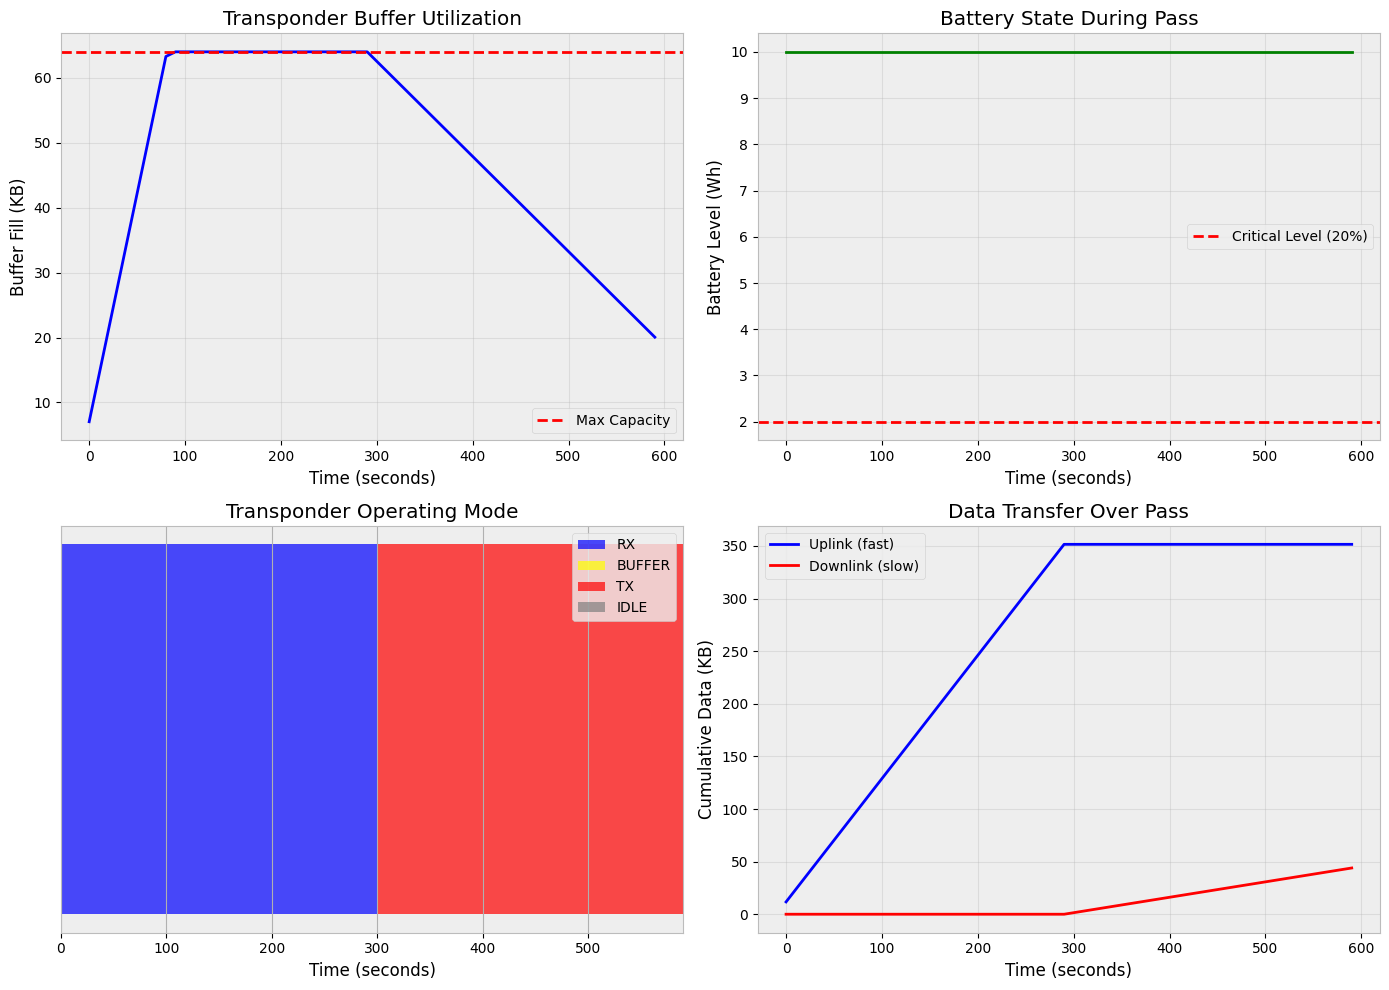

In [19]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

time_axis = np.arange(len(transponder.buffer_history)) * 10

# Buffer fill over time
ax1.plot(time_axis, np.array(transponder.buffer_history) / 1024, 'b-', linewidth=2)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Buffer Fill (KB)')
ax1.set_title('Transponder Buffer Utilization')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=config.buffer_size_bytes/1024, color='r', linestyle='--', label='Max Capacity')
ax1.legend()

# Battery level over time
ax2.plot(time_axis, transponder.battery_history, 'g-', linewidth=2)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Battery Level (Wh)')
ax2.set_title('Battery State During Pass')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=config.battery_capacity_wh * 0.2, color='r', linestyle='--', label='Critical Level (20%)')
ax2.legend()

# Mode timeline
mode_colors = {1: 'blue', 2: 'yellow', 3: 'red', 4: 'gray'}
mode_names = {1: 'RX', 2: 'BUFFER', 3: 'TX', 4: 'IDLE'}
for i, current_mode in enumerate(transponder.mode_history):
    ax3.barh(0, 10, left=i*10, color=mode_colors[current_mode], alpha=0.7, height=0.5)
ax3.set_xlabel('Time (seconds)')
ax3.set_yticks([])
ax3.set_title('Transponder Operating Mode')
ax3.set_xlim(0, max(time_axis))

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, alpha=0.7, label=mode_names[mode_id]) for mode_id, color in mode_colors.items()]
ax3.legend(handles=legend_elements, loc='upper right');

# Data flow rates
cumulative_rx = np.cumsum([transponder.config.uplink_rate_bps / 8 * 10 if m == 1 else 0 for m in transponder.mode_history]) / 1024
cumulative_tx = np.cumsum([transponder.config.downlink_rate_bps / 8 * 10 if m == 3 else 0 for m in transponder.mode_history]) / 1024
ax4.plot(time_axis, cumulative_rx, 'b-', linewidth=2, label='Uplink (fast)')
ax4.plot(time_axis, cumulative_tx, 'r-', linewidth=2, label='Downlink (slow)')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Cumulative Data (KB)')
ax4.set_title('Data Transfer Over Pass')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save to current directory instead
plt.savefig('funcube_plus_simulation.png', dpi=150)
print("\n✓ Simulation plot saved to current directory")
plt.show()